# Fitting $\Delta\varepsilon_{AI}$ to inducer mutants 

In [1]:
import sys
import pandas as pd
import numpy as np
import pystan
import bokeh.io
import bokeh.plotting
sys.path.insert(0, '../../')
import mut.thermo
import mut.stats
import mut.bayes
bokeh.io.output_notebook()

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Loading BokehJS ...

In this notebook, we investigate a method to determine if particular mutants in the inducer binding domain can alter the allosteric energy difference $\Delta\varepsilon_{AI}$.  

In [2]:
# Load the data
data = pd.read_csv('../../data/csv/compiled_data.csv')

# Restrict the data.
data = data[data['fold_change'] > 0]
data = data[(data['mutant'] == 'Y20I') | (data['mutant']=='Q294K') | (data['mutant']=='Y20I-Q294K')]

In [ ]:
# Define the three models. 
model = pystan.StanModel('../stan/DNA_binding_energy.stan')

In [21]:
# Assemble the data dictionary
epR_data = data[(data['mutant']=='Y20I') & (data['IPTGuM']==0)]
data_dict = {'N':len(epR_data), 'R':epR_data['repressors'], 'Nns':4.6E6, 'c':epR_data['IPTGuM'],
            'ka':139E-6, 'ki':0.53E-6, 'ep_ai':4.5, 'n_sites':2, 'fc':epR_data['fold_change']}
samples = model.sampling(data_dict, iter=5000, chains=4)

# Compute the statistics and dataframe. 
epR_df = mut.bayes.chains_to_dataframe(samples, varnames=['epR'])
epR_stats = mut.stats.compute_statistics(epR_df)
epR_stats

/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


,parameter,mode,hpd_min,hpd_max
0,epR,-9.834516,-9.979688,-9.673158
1,sigma,0.185278,0.138482,0.259845


In [33]:
# Compute the theoretical curve
rep_range = np.logspace(0, 4, 500)
theo = mut.thermo.SimpleRepression(R=rep_range, ep_r=epR_stats[epR_stats['parameter']=='epR']['mode'].values[0]).fold_change()

# Compute the means and sem for the data. 
grouped = pd.DataFrame(epR_data.groupby('repressors').apply(mut.stats.compute_mean_sem)).reset_index()
# Plot the fit.
p = bokeh.plotting.figure(plot_width=600, plot_height=400, x_axis_type='log',
                         y_axis_type='log', x_axis_label='repressors per cell',
                         y_axis_label='fold-change')
p.circle(grouped['repressors'], grouped['mean'], color='dodgerblue', size=6)
yerrs = []
xpos = []
for i in range(len(grouped)):
    x = grouped.iloc[i]['repressors']
    mean = grouped.iloc[i]['mean']
    sem = grouped.iloc[i]['sem']
    xpos.append((x,x))
    yerrs.append((mean - sem, mean + sem))
    
p.multi_line(xpos, yerrs, color='dodgerblue', line_width=2) 
p.line(rep_range, theo, color='dodgerblue', line_width=2)
bokeh.io.show(p)

## Fitting $\Delta\varepsilon_{AI}$ 

Using only the $c = 0$ data, fit the allosteric energy to the inducer mutant Q294K


In [52]:
# Load the energy fitting model
allo_model = pystan.StanModel('../stan/allosteric_energy.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_77654e917c209fa9a235a319946cc0e9 NOW.


In file included from /var/folders/2q/lvh2zsws3lxckq8xtkn_84z80000gn/T/tmpin3yaf7k/stanfit4anon_model_77654e917c209fa9a235a319946cc0e9_8362434532802113004.cpp:599:
In file included from /anaconda3/lib/python3.6/site-packages/numpy/core/include/numpy/arrayobject.h:4:
In file included from /anaconda3/lib/python3.6/site-packages/numpy/core/include/numpy/ndarrayobject.h:18:
In file included from /anaconda3/lib/python3.6/site-packages/numpy/core/include/numpy/ndarraytypes.h:1816:
/anaconda3/lib/python3.6/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:15:2: warning: "Using deprecated NumPy API, disable it by "          "#defining NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, disable it by " \
 ^
/var/folders/2q/lvh2zsws3lxckq8xtkn_84z80000gn/T/tmpin3yaf7k/stanfit4anon_model_77654e917c209fa9a235a319946cc0e9_8362434532802113004.cpp:9155:30: warning: comparison of integers of different signs: 'Py_ssize_t' (aka 'long') and 'std::_

In [53]:
# Restrict the data to the epsilon_AI
epAI_data = data[(data['mutant']=='Q294K') & (data['IPTGuM']==0)]

# Define the data dictionary and sample. 
data_dict = {'N':len(epAI_data), 'R':epAI_data['repressors'], 'epR':-13.9,
            'Nns':4.6E6, 'fc':epAI_data['fold_change']}

# Sample
allo_samples = allo_model.sampling(data_dict, iter=10000, chains=4)
allo_df = mut.bayes.chains_to_dataframe(allo_samples, varnames=['ep_ai'])
allo_stats = mut.stats.compute_statistics(allo_df)

/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [54]:
allo_samples

Inference for Stan model: anon_model_77654e917c209fa9a235a319946cc0e9.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
ep_ai      -2.49  1.4e-3    0.1  -2.68  -2.54  -2.49  -2.44  -2.29   5005    1.0
sigma       0.16  1.1e-3   0.08   0.08   0.11   0.14   0.18   0.35   5155    1.0
log_fc[0]  -1.65 4.7e-166.7e-16  -1.65  -1.65  -1.65  -1.65  -1.65      2    nan
log_fc[1]  -1.87     0.0    0.0  -1.87  -1.87  -1.87  -1.87  -1.87      2    nan
log_fc[2]  -1.68 4.7e-166.7e-16  -1.68  -1.68  -1.68  -1.68  -1.68      2    nan
log_fc[3]  -1.59 3.1e-164.4e-16  -1.59  -1.59  -1.59  -1.59  -1.59      2    nan
log_fc[4]  -1.83 3.1e-164.4e-16  -1.83  -1.83  -1.83  -1.83  -1.83      2    nan
log_fc[5]  -1.84 4.7e-166.7e-16  -1.84  -1.84  -1.84  -1.84  -1.84      2    nan
lp__        7.05    0.02   1.23   3.76   6.57   7.42   7.92   8.24   4563    1.0

In [55]:
# Plot the distribution for ep_ai
hist, edges = np.histogram(allo_df['ep_ai'], density=True, bins=100)
p = bokeh.plotting.figure(plot_width=600, plot_height=400, 
                          x_axis_label='allosteric energy',
                          y_axis_label='frequency')
p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
        fill_color="dodgerblue")
bokeh.io.show(p)

In [63]:
p = bokeh.plotting.figure(plot_width=600, height=400, x_axis_type='log',
                          y_axis_type='log', x_axis_label='repressors per cell',
                          y_axis_label='fold-change')

# Compute the theoretical fit. 
theo = mut.thermo.SimpleRepression(rep_range, -13.9, ep_ai=-2.5, effector_conc=0, n_sites=2,
                                  ka=0.1, ki=0.1).fold_change() 
theo2 = mut.thermo.SimpleRepression(rep_range, -13.9, ep_ai=4.5, effector_conc=0, n_sites=2,
                                  ka=0.1, ki=0.1).fold_change() 
p.line(rep_range, theo, line_width=2, color='dodgerblue', legend = 'Δε = -2.5')
p.line(rep_range, theo2, line_width=2, color='tomato', legend = 'Δε = +4.5')
p.circle(epAI_data['repressors'], epAI_data['fold_change'], color='slategray', legend='data')
p.title.text = 'Q294K leakiness'
bokeh.io.show(p)

## Fit $K_A/K_I$ with new $\Delta\varepsilon_{AI}$ 

In [113]:
# Load the model.
kaki_model = pystan.StanModel('../stan/KaKi_fitting.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4010181148846a076156e798899c2057 NOW.


In file included from /var/folders/2q/lvh2zsws3lxckq8xtkn_84z80000gn/T/tmp_588mr6k/stanfit4anon_model_4010181148846a076156e798899c2057_3942078589066626045.cpp:599:
In file included from /anaconda3/lib/python3.6/site-packages/numpy/core/include/numpy/arrayobject.h:4:
In file included from /anaconda3/lib/python3.6/site-packages/numpy/core/include/numpy/ndarrayobject.h:18:
In file included from /anaconda3/lib/python3.6/site-packages/numpy/core/include/numpy/ndarraytypes.h:1816:
/anaconda3/lib/python3.6/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:15:2: warning: "Using deprecated NumPy API, disable it by "          "#defining NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, disable it by " \
 ^
/var/folders/2q/lvh2zsws3lxckq8xtkn_84z80000gn/T/tmp_588mr6k/stanfit4anon_model_4010181148846a076156e798899c2057_3942078589066626045.cpp:9155:30: warning: comparison of integers of different signs: 'Py_ssize_t' (aka 'long') and 'std::_

In [119]:
# Restrict the data
kaki_data = data[(data['mutant']=='Q294K')]

# Assemble the data dictionary. 
data_dict = {'N':len(kaki_data), 'R':kaki_data['repressors'], 'Nns':4.6E6,
            'c':kaki_data['IPTGuM'], 'epR':-13.9, 'ep_ai':-2.5,
            'n_sites':2, 'fc':kaki_data['fold_change']}

# Sample and convert to dataframe/statistics.
kaki_samples = kaki_model.sampling(data_dict, iter=10000, chains=4)
kaki_df = mut.bayes.chains_to_dataframe(kaki_samples, varnames=['ka', 'ki'])
kaki_stats = mut.stats.compute_statistics(kaki_df)
kaki_stats

/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


,parameter,mode,hpd_min,hpd_max
0,ka,639.798913,378.450737,1056.930523
1,ki,107.461725,75.792683,142.678808
2,sigma,0.089770,0.077311,0.108116


In [120]:
kaki_samples

Inference for Stan model: anon_model_4010181148846a076156e798899c2057.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
ka    674.58    2.79 181.39 367.39 536.97 654.99 801.83 1048.5   4226    1.0
ki    109.03    0.27  17.65  75.91  96.56 108.64 121.58 142.88   4204    1.0
sigma   0.09  9.3e-5 7.9e-3   0.08   0.09   0.09    0.1   0.11   7235    1.0
ep_a    6.48  4.2e-3   0.28   5.91   6.29   6.48   6.69   6.96   4344    1.0
ep_i    4.68  2.5e-3   0.17   4.33   4.57   4.69    4.8   4.96   4310    1.0
lp__  143.05    0.01   1.15 140.04 142.56 143.34 143.86 144.35   6242    1.0

Samples were drawn using NUTS at Sat Jun  2 13:02:23 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [128]:
# Plot the fits. 
ka = kaki_stats[kaki_stats['parameter'] == 'ka']['mode'].values[0]
ki = kaki_stats[kaki_stats['parameter'] == 'ki']['mode'].values[0]
R = 260
c_range = np.logspace(-10, -2, 500)
theo = mut.thermo.SimpleRepression(R, -13.9, ep_ai=-2.5, effector_conc=c_range, 
                                   ka=ka/1E6, ki=ki/1E6).fold_change() 

# Set up the figure.
p = bokeh.plotting.figure(plot_width=600, plot_height=400, x_axis_type='log',
                          x_axis_label='IPTG [M]', y_axis_label='fold-change')
p.line(c_range, theo, color='dodgerblue', line_width=2)

grouped = pd.DataFrame(kaki_data.groupby(['IPTGuM']).apply(
                        mut.stats.compute_mean_sem)).reset_index()

xpos, yerr = [], []
for i in range(len(grouped)):
    x = grouped.iloc[i]['IPTGuM'] / 1E6
    if x == 0:
        x == 1E-10
    mean = grouped.iloc[i]['mean']
    sem = grouped.iloc[i]['sem']
    xpos.append((x, x))
    yerr.append((mean - sem, mean+sem))
p.circle(grouped['IPTGuM']/1E6, grouped['mean'], color='dodgerblue')
p.circle(1E-10, grouped.loc[grouped['IPTGuM']==0]['mean'], color='dodgerblue')
p.multi_line(xpos, yerr, color='dodgerblue', line_width=2)
bokeh.io.show(p)

In [117]:
ki

106.9946148113277

In [125]:
mut.thermo.MWC?

In [127]:
xpos

[(0.0, 0.0),
 (1.0000000000000001e-07, 1.0000000000000001e-07),
 (5e-06, 5e-06),
 (1e-05, 1e-05),
 (2.5e-05, 2.5e-05),
 (5e-05, 5e-05),
 (7.5e-05, 7.5e-05),
 (0.0001, 0.0001),
 (0.00025, 0.00025),
 (0.0005, 0.0005),
 (0.001, 0.001),
 (0.005, 0.005)]

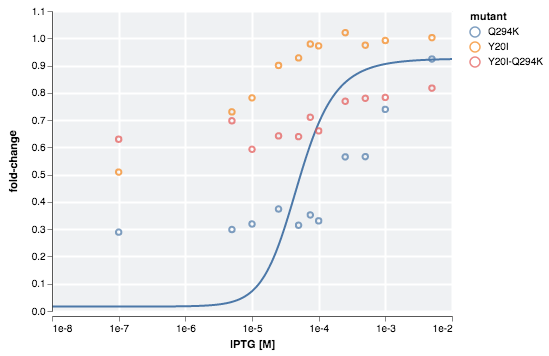

In [32]:
import altair as alt
alt.renderers.enable('notebook')
custom = alt.Config(view={'fill':'#eff1f3'}, 
                    axis={'gridColor': '#ffffff', 'gridWidth': 2, 
                          'labelFont': 'Helvetica', 'titleFont':'Helvetica', 
                          'titleFontWeight': 'bold', 'domainColor':'#3c3c3c', 
                          'domainWidth':0.75})


grouped = pd.DataFrame(data.groupby(['mutant', 'IPTGuM']).apply(mut.stats.compute_mean_sem)).reset_index()
grouped['IPTGuM'] *= 1E-6
grouped = grouped[grouped['IPTGuM']!=0]

# Compute some fits and plot them.
c_range = np.logspace(-8, -2, 500)
fc = mut.thermo.SimpleRepression(R=260, ep_r=-13.9, ka=139E-6, ki=0.53E-6, ep_ai=4.5, effector_conc=c_range).fold_change()
base = alt.Chart(grouped).mark_point().encode(
    x=alt.X('IPTGuM', axis=alt.Axis(format='e', tickCount=5, offset=5), 
            title='IPTG [M]', scale={'type':'log'}), 
    y=alt.Y('mean', title='fold-change'),    
    color='mutant').interactive()

x_df = pd.DataFrame(np.array([c_range, fc]).T, columns=['c', 'fc'])
fit = alt.Chart(x_df).mark_line().encode(x=alt.X('c', scale={'type': 'log'}, title='IPTG [M]'), y=alt.Y('fc', title='fold-change')).interactive()

alt.layer(fit, base, config=custom)


In [24]:
x_df

,c,fc
0,1.000000e-08,0.016180
1,1.028073e-08,0.016180
2,1.056935e-08,0.016181
3,1.086606e-08,0.016181
4,1.117111e-08,0.016181
5,1.148472e-08,0.016181
6,1.180713e-08,0.016181
7,1.213859e-08,0.016182
8,1.247936e-08,0.016182
9,1.282970e-08,0.016182


In [9]:
custom

Config({
  axis: {'gridColor': '#ffffff', 'gridWidth': 2, 'labelFont': 'Helvetica', 'titleFont': 'Helvetica', 'titleFontWeight': 'bold', 'domainColor': '#3c3c3c', 'domainWidth': 0.75},
  view: {'fill': '#eff1f3'}
})

In [237]:
alt.Axis?

In [13]:
alt.Chart?